In [2]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import os, re
import matplotlib.colors as mcolors
import csv
from scipy.signal import savgol_filter
def find_closest(value, series):
    return series.iloc[(series - value).abs().argsort()[:1]].values[0]

def find_edge_position(energy, intensity, monoE_min, monoE_max, smooth):
    """
    Finds the edge position in the given energy vs. intensity data.

    Parameters:
    - energy: numpy array of energy values
    - intensity: numpy array of intensity values
    - smoothing_window: window size for Savitzky-Golay filter (default is 11)
    - polyorder: polynomial order for Savitzky-Golay filter (default is 3)

    Returns:
    - edge_position_idx: index of the detected edge position
    """
    # Step 1: Normalize the intensity data
    normalized_data = intensity / np.max(intensity)
    
    if smooth == "yes":
        # Optional: Smooth the data to reduce noise
        smoothed_data = savgol_filter(normalized_data, 11, 3)
        # Step 2: Calculate the first derivative
        first_derivative = np.gradient(smoothed_data)
    elif smooth == "no":
        # Step 2: Calculate the first derivative
        first_derivative = np.gradient(normalized_data)
    
    # Step 3: Find the index of the maximum in the first derivative
    max_index = np.argmax(first_derivative)
    
    # Step 4: Calculate the second derivative
    second_derivative = np.gradient(first_derivative)
    
    # Step 5: Find the zero-crossing in the second derivative near the maximum
    zero_crossing_indices = np.where(np.diff(np.sign(second_derivative)))[0]
    
    # Filter zero_crossing_indices to those between monoE_min and monoE_max
    valid_indices = [idx for idx in zero_crossing_indices if monoE_min <= energy[idx] <= monoE_max]
    
    if not valid_indices:
        raise ValueError("No valid edge position found within the specified energy range.")
    
    # Step 7: Find the zero-crossing closest to the maximum in the first derivative
    edge_position_idx = valid_indices[np.abs(np.array(valid_indices) - max_index).argmin()]
    edge_position = energy[edge_position_idx]  # Access energy value directly using the index
    
    return edge_position

### Plot REF Fe (10 um) from data + Calculation of energy shift of beamline

002_S7-NiFe-6Sm_Activation_2
003_S7-NiFe-6Sm_Reaction_1
004_S7-NiFe-6Sm_PM_RT_2
S7-FeNi-6Sm_Activation_ramp_1


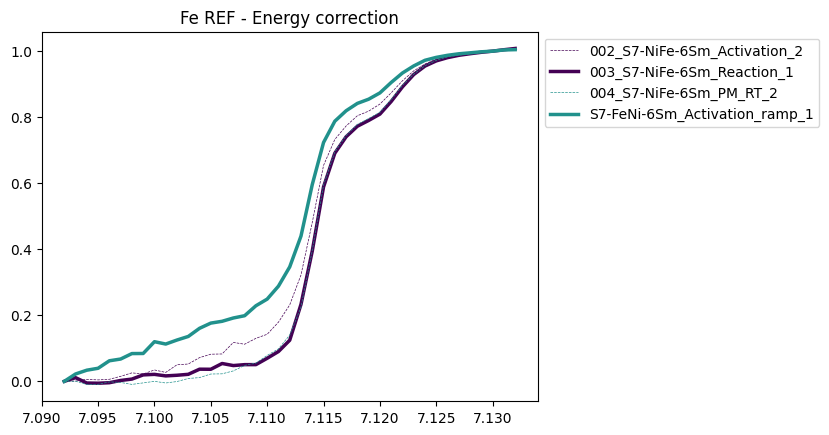

In [2]:
search_string = "Fe_REF_merged"
var1="ionch1" # diode1 / roiX
var2="mcaRt" # AS_IC / mcaLt

monoE_min = 7.08
monoE_max = 7.13
edge = 7.112
smooth = "yes"
# Fe K-edge is at 7.112 KeV

labeled_files= []
for root, dirs, files in os.walk("."):
    files.sort() 
    for i, file in enumerate(files):
        if search_string in file:
            subfolder_name = os.path.basename(root)
            file_path = os.path.join(root, file)
            label = f"{subfolder_name}_{i % 2 +1}"
            labeled_files.append((file_path, label))
labeled_files.sort()

cmap = plt.cm.viridis
norm = mcolors.Normalize(vmin=0, vmax=len(labeled_files) / 2)
energ_calib_Cu_REF_list = []
for idx, (file_path, label) in enumerate(labeled_files):
    print (label)
    result_df = pd.read_csv(file_path)

    closest_monoE1 = find_closest(monoE_min, result_df['monoE'])
    closest_monoE2 = find_closest(monoE_max, result_df['monoE'])
    signal_min = result_df.loc[result_df['monoE'] == closest_monoE1, f'{var1}/{var2}_mean'].values[0]
    signal_max = result_df.loc[result_df['monoE'] == closest_monoE2, f'{var1}/{var2}_mean'].values[0]
    color = cmap(norm(idx//2))  # Use the same color for pairs

    x = result_df['monoE']
    result_df["I_norm"]=(result_df[f'{var1}/{var2}_mean'] - signal_min)/(signal_max - signal_min)
    y = -0.0*idx + (result_df["I_norm"])
    err = (result_df[f'{var1}/{var2}_std'] - signal_min)/(signal_max - signal_min)
    energy_position_ref_data = find_edge_position(result_df['monoE'].values, result_df["I_norm"].values, monoE_min, monoE_max, smooth)

    #target_value = 0.5
    #idx_before = result_df[result_df["I_norm"] <= target_value].index[-1]
    #idx_after = result_df[result_df["I_norm"] > target_value].index[0]
    #x0, y0 = result_df.loc[idx_before, "I_norm"], result_df.loc[idx_before, 'monoE']
    #x1, y1 = result_df.loc[idx_after, "I_norm"], result_df.loc[idx_after, 'monoE']
    #interpolated_monoE = y0 + (target_value - x0) * (y1 - y0) / (x1 - x0)
    energ_calib_Cu_REF_list.append((label,float(energy_position_ref_data)))


    if label.endswith('_1'):
        plt.plot(x, y, label=label, linewidth=2.5, color=color)
    elif label.endswith('_2'):
        plt.plot(x, y, color=color, linestyle='--', linewidth=0.5, label=label)
    #plt.fill_between(x, y - err,y + err, color=color, alpha=0.2)
#plt.ylim([1.75,2.93])
#plt.xlim([7.15,9.])
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title("Fe REF - Energy correction")

plt.savefig('Fe_REF_NEXAFS.png')


002_S7-NiFe-6Sm_Activation_2: has the edge at 7.1130, the energy shift is -0.001
003_S7-NiFe-6Sm_Reaction_1: has the edge at 7.1140, the energy shift is -0.002
004_S7-NiFe-6Sm_PM_RT_2: has the edge at 7.1140, the energy shift is -0.002
S7-FeNi-6Sm_Activation_ramp_1: has the edge at 7.1130, the energy shift is -0.001


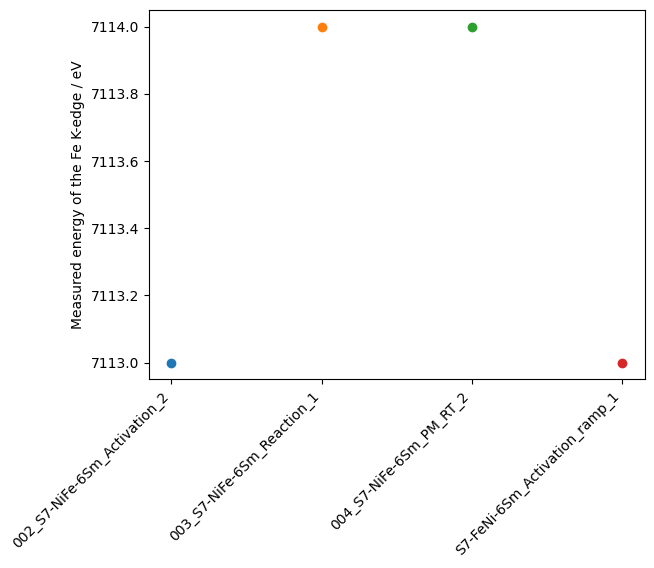

In [3]:
for (lab, en) in energ_calib_Cu_REF_list:
    plt.scatter(lab, en*1000)
    print(f"{lab}: has the edge at {en:.4f}, the energy shift is {edge-en:.3f}")
plt.xticks(rotation=45, ha='right')
plt.ylabel ("Measured energy of the Fe K-edge / eV")
plt.savefig('Fe_REF_energy_shift.png')


### Plot Cu K-edge EXAFS

001_Cu-6Sm_Pristine_RT_2
003_Cu-6Sm_Activation_dwell_1
003_Cu-6Sm_Activation_dwell_2
005_Cu-6Sm_Reaction_T1_1
005_Cu-6Sm_Reaction_T1_2
007_Cu-6Sm_Reaction_T2_1
007_Cu-6Sm_Reaction_T2_2
009_Cu-6Sm_Reaction_T3_1
009_Cu-6Sm_Reaction_T3_2
011_Cu-6Sm_Reaction_T4_1
011_Cu-6Sm_Reaction_T4_2
013_Cu-6Sm_Reaction_T5_1
013_Cu-6Sm_Reaction_T5_2
015_Cu-6Sm_PM_RT_1


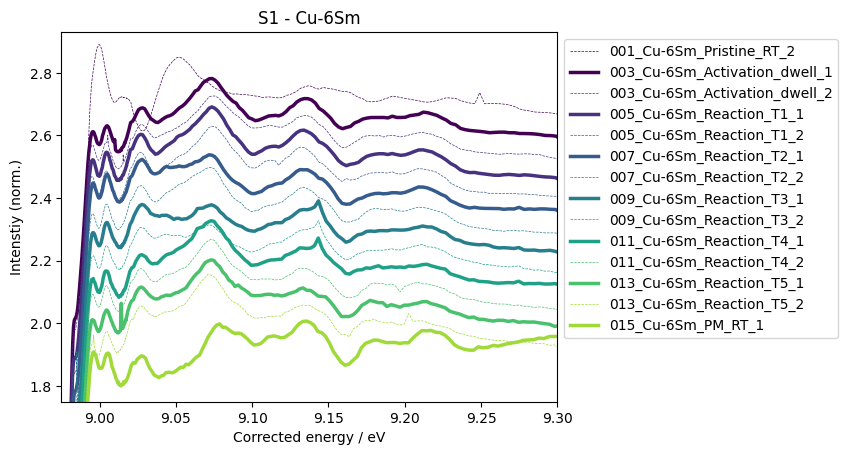

In [76]:
search_string = "Cu_K_EXAFS_merged"
var1="diode1"
var2="AS_IC"
monoE_min = 8.95
monoE_max = 9.2

labeled_files= []
for root, dirs, files in os.walk("."):
    files.sort() 
    for i, file in enumerate(files):
        if search_string in file:
            subfolder_name = os.path.basename(root)
            file_path = os.path.join(root, file)
            label = f"{subfolder_name}_{i % 2 + 1}"
            labeled_files.append((file_path, label))
labeled_files.sort()

cmap = plt.cm.viridis
norm = mcolors.Normalize(vmin=0, vmax=len(labeled_files) / 2)
for idx, (file_path, label) in enumerate(labeled_files):
    print (label)
    result_df = pd.read_csv(file_path)

    closest_monoE1 = find_closest(monoE_min, result_df['monoE'])
    closest_monoE2 = find_closest(monoE_max, result_df['monoE'])

    signal_min = result_df.loc[result_df['monoE'] == closest_monoE1, f'{var1}/{var2}_mean'].values[0]
    signal_max = result_df.loc[result_df['monoE'] == closest_monoE2, f'{var1}/{var2}_mean'].values[0]

    color = cmap(norm(idx // 2))  # Use the same color for pairs

    deltaE = idx*1e-3/len(labeled_files)
    x = -deltaE + result_df['monoE']
    y = -0.06*idx + np.exp((result_df[f'{var1}/{var2}_mean'] - signal_min)/(signal_max - signal_min))
    err = (result_df[f'{var1}/{var2}_std'] - signal_min)/(signal_max - signal_min)

    if label.endswith('_1'):
        plt.plot(x, y, label=label, linewidth=2.5, color=color)
    elif label.endswith('_2'):
        plt.plot(x, y, color=color, linestyle='--', linewidth=0.5, label=label)
    #plt.fill_between(x, y - err,y + err, color=color, alpha=0.2)
plt.ylim([1.75,2.93])
plt.xlim([8.975,9.3])
plt.xlabel ("Corrected energy / eV")
plt.ylabel ("Intenstiy (norm.)")
plt.title ("S1 - Cu-6Sm")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.savefig('Cu_EXAFS_S1.png')

001_Cu-6Sm_Pristine_RT_2
003_Cu-6Sm_Activation_dwell_1
003_Cu-6Sm_Activation_dwell_2
005_Cu-6Sm_Reaction_T1_1
005_Cu-6Sm_Reaction_T1_2
007_Cu-6Sm_Reaction_T2_1
007_Cu-6Sm_Reaction_T2_2
009_Cu-6Sm_Reaction_T3_1
009_Cu-6Sm_Reaction_T3_2
011_Cu-6Sm_Reaction_T4_1
011_Cu-6Sm_Reaction_T4_2
013_Cu-6Sm_Reaction_T5_1
013_Cu-6Sm_Reaction_T5_2
015_Cu-6Sm_PM_RT_1


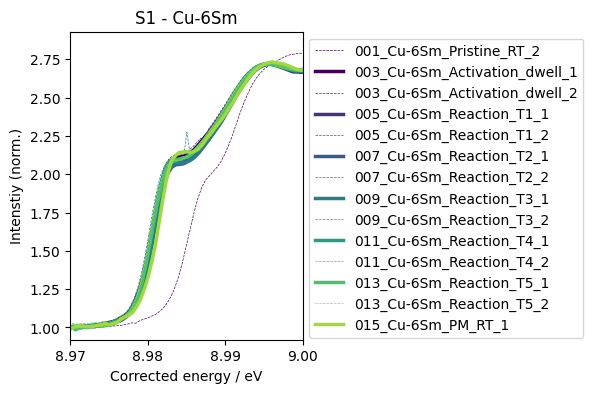

In [77]:
search_string = "Cu_K_EXAFS_merged"
var1="diode1"
var2="AS_IC"
monoE_min = 8.97
monoE_max = 8.996

labeled_files= []
for root, dirs, files in os.walk("."):
    files.sort() 
    for i, file in enumerate(files):
        if search_string in file:
            subfolder_name = os.path.basename(root)
            file_path = os.path.join(root, file)
            label = f"{subfolder_name}_{i % 2 + 1}"
            labeled_files.append((file_path, label))
labeled_files.sort()

plt.figure(figsize=(3, 4))
cmap = plt.cm.viridis
norm = mcolors.Normalize(vmin=0, vmax=len(labeled_files) / 2)
for idx, (file_path, label) in enumerate(labeled_files):
    print (label)
    result_df = pd.read_csv(file_path)

    closest_monoE1 = find_closest(monoE_min, result_df['monoE'])
    closest_monoE2 = find_closest(monoE_max, result_df['monoE'])

    signal_min = result_df.loc[result_df['monoE'] == closest_monoE1, f'{var1}/{var2}_mean'].values[0]
    signal_max = result_df.loc[result_df['monoE'] == closest_monoE2, f'{var1}/{var2}_mean'].values[0]

    color = cmap(norm(idx // 2))  # Use the same color for pairs

    deltaE = idx*1e-3/len(labeled_files)
    x = -deltaE + result_df['monoE']
    y = -0.0*idx + np.exp((result_df[f'{var1}/{var2}_mean'] - signal_min)/(signal_max - signal_min))
    err = (result_df[f'{var1}/{var2}_std'] - signal_min)/(signal_max - signal_min)

    if label.endswith('_1'):
        plt.plot(x, y, label=label, linewidth=2.5, color=color)
    elif label.endswith('_2'):
        plt.plot(x, y, color=color, linestyle='--', linewidth=0.5, label=label)
    #plt.fill_between(x, y - err,y + err, color=color, alpha=0.2)
plt.ylim([0.92,2.93])
plt.xlim([8.97,9.0])
plt.xlabel ("Corrected energy / eV")
plt.ylabel ("Intenstiy (norm.)")
plt.title ("S1 - Cu-6Sm")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.savefig('Cu_NEXAFS_S1.png')

### Plot Ce L3-edge NEXAFS

[('./001_Cu-6Sm_Pristine_RT/Data_Ce_L3_EXAFS_merged_scans_80_85.csv', '001_Cu-6Sm_Pristine_RT_2'), ('./003_Cu-6Sm_Activation_dwell/Data_Ce_L3_EXAFS_merged_scans_9_14.csv', '003_Cu-6Sm_Activation_dwell_2'), ('./005_Cu-6Sm_Reaction_T1/Data_Ce_L3_EXAFS_merged_scans_8_13.csv', '005_Cu-6Sm_Reaction_T1_2'), ('./007_Cu-6Sm_Reaction_T2/Data_Ce_L3_EXAFS_merged_scans_8_13.csv', '007_Cu-6Sm_Reaction_T2_2'), ('./009_Cu-6Sm_Reaction_T3/Data_Ce_L3_EXAFS_merged_scans_12_17.csv', '009_Cu-6Sm_Reaction_T3_2'), ('./011_Cu-6Sm_Reaction_T4/Data_Ce_L3_EXAFS_merged_scans_16_23.csv', '011_Cu-6Sm_Reaction_T4_2'), ('./013_Cu-6Sm_Reaction_T5/Data_Ce_L3_EXAFS_merged_scans_8_13.csv', '013_Cu-6Sm_Reaction_T5_2'), ('./015_Cu-6Sm_PM_RT/Data_Ce_L3_EXAFS_merged_scans_45_50.csv', '015_Cu-6Sm_PM_RT_2')]
001_Cu-6Sm_Pristine_RT_2
003_Cu-6Sm_Activation_dwell_2
005_Cu-6Sm_Reaction_T1_2
007_Cu-6Sm_Reaction_T2_2
009_Cu-6Sm_Reaction_T3_2
011_Cu-6Sm_Reaction_T4_2
013_Cu-6Sm_Reaction_T5_2
015_Cu-6Sm_PM_RT_2


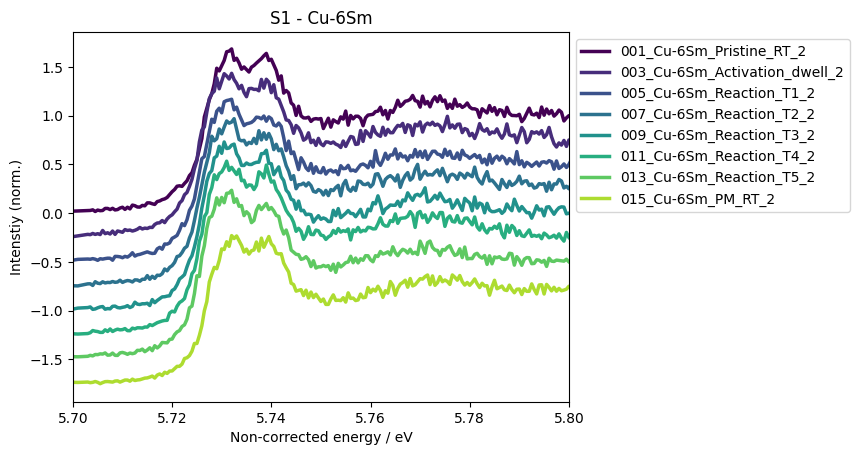

In [80]:
search_string = "Ce_L3_EXAFS_merged"
var1="roi1" # diode1
var2="mcaLt" # AS_IC
monoE_min = 5.68
monoE_max = 5.8

labeled_files= []
for root, dirs, files in os.walk("."):
    files.sort() 
    for i, file in enumerate(files):
        if search_string in file:
            subfolder_name = os.path.basename(root)
            file_path = os.path.join(root, file)
            label = f"{subfolder_name}_{i % 2 + 1}"
            labeled_files.append((file_path, label))
labeled_files.sort()
print (labeled_files)
cmap = plt.cm.viridis
norm = mcolors.Normalize(vmin=0, vmax=len(labeled_files))
for idx, (file_path, label) in enumerate(labeled_files):
    print (label)
    result_df = pd.read_csv(file_path)

    closest_monoE1 = find_closest(monoE_min, result_df['monoE'])
    closest_monoE2 = find_closest(monoE_max, result_df['monoE'])

    signal_min = result_df.loc[result_df['monoE'] == closest_monoE1, f'{var1}/{var2}_mean'].values[0]
    signal_max = result_df.loc[result_df['monoE'] == closest_monoE2, f'{var1}/{var2}_mean'].values[0]

    color = cmap(norm(idx // 1))  # Use the same color for pairs

    x = result_df['monoE']
    y = -0.25*idx + ((result_df[f'{var1}/{var2}_mean'] - signal_min)/(signal_max - signal_min))
    err = (result_df[f'{var1}/{var2}_std'] - signal_min)/(signal_max - signal_min)

    if label.endswith('_2'):
        plt.plot(x, y, label=label, linewidth=2.5, color=color)
    elif label.endswith('_1'):
        plt.plot(x, y, color=color, linestyle='--', linewidth=1.5, label=label)
    #plt.fill_between(x, y - err,y + err, color=color, alpha=0.2)

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.xlim([5.7,5.8])
plt.xlabel ("Non-corrected energy / eV")
plt.ylabel ("Intenstiy (norm.)")
plt.title ("S1 - Cu-6Sm")

plt.savefig('Ce_NEXAFS_S1.png')

### Fe K-edge NEXAFS of data- Energy correction

In [20]:
search_string = "Fe_NEXAFS_merged"

energy_shifts = [-0.001, -0.002,-0.002,-0.001]

labeled_files= []
for root, dirs, files in os.walk("."):
    files.sort() 
    for i, file in enumerate(files):
        if search_string in file:
            subfolder_name = os.path.basename(root)
            file_path = os.path.join(root, file)
            label = f"{subfolder_name}_{i % 2 +1}"
            labeled_files.append((file_path, label))
labeled_files.sort()

for idx,(file_path, label) in enumerate(labeled_files):
    print (label)
    result_df = pd.read_csv(file_path)
    result_df["monoE"] = result_df["monoE"] + energy_shifts[idx]
    result_df.to_csv(file_path[:-4]+"_EC.dat")
    

002_S7-NiFe-6Sm_Activation_2
003_S7-NiFe-6Sm_Reaction_1
004_S7-NiFe-6Sm_PM_RT_2
S7-FeNi-6Sm_Activation_ramp_1


### Edge position of merged Fe NEXAFS of data

./002_S7-NiFe-6Sm_Activation/Data_Fe_NEXAFS_merged_scans_12_15_EC.dat
./003_S7-NiFe-6Sm_Reaction/Data_Fe_NEXAFS_merged_scans_10_13_EC.dat
./004_S7-NiFe-6Sm_PM_RT/Data_Fe_NEXAFS_merged_scans_2_3_EC.dat
./S7-FeNi-6Sm_Activation_ramp/Data_Fe_NEXAFS_merged_scans_19_20_EC.dat
[('002_S7-NiFe-6Sm_Activation_1', 7.127), ('003_S7-NiFe-6Sm_Reaction_2', 7.123), ('004_S7-NiFe-6Sm_PM_RT_1', 7.1240000000000006), ('S7-FeNi-6Sm_Activation_ramp_2', 7.126)]


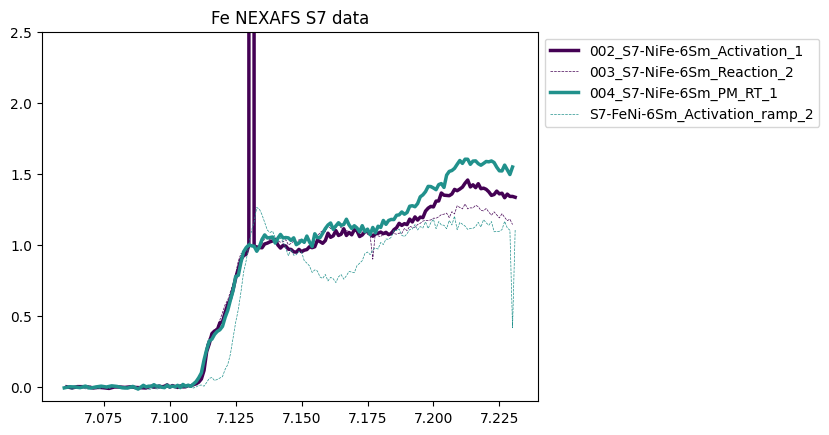

In [23]:
search_string = "Fe_NEXAFS_merged"
search_string_2 = "EC"
var1="roi5" # diode1 / roiX / ionch1
var2="mcaLt" # AS_IC / mcaLt mcaRt

monoE_min = 7.10
monoE_max = 7.13
#edge = 7.112
smooth = "yes"
# Fe K-edge is at 7.112 KeV

labeled_files= []
for root, dirs, files in os.walk("."):
    files.sort() 
    for i, file in enumerate(files):
        if search_string in file and search_string_2 in file:
            subfolder_name = os.path.basename(root)
            file_path = os.path.join(root, file)
            label = f"{subfolder_name}_{i % 2 +1}"
            labeled_files.append((file_path, label))
labeled_files.sort()

cmap = plt.cm.viridis
norm = mcolors.Normalize(vmin=0, vmax=len(labeled_files) / 2)
energ_calib_Fe_NEXAFS_list = []
for idx, (file_path, label) in enumerate(labeled_files):
    print (file_path)
    result_df = pd.read_csv(file_path)

    closest_monoE1 = find_closest(monoE_min, result_df['monoE'])
    closest_monoE2 = find_closest(monoE_max, result_df['monoE'])
    signal_min = result_df.loc[result_df['monoE'] == closest_monoE1, f'{var1}/{var2}_mean'].values[0]
    signal_max = result_df.loc[result_df['monoE'] == closest_monoE2, f'{var1}/{var2}_mean'].values[0]
    color = cmap(norm(idx//2))  # Use the same color for pairs

    x = result_df['monoE']
    result_df["I_norm"]=(result_df[f'{var1}/{var2}_mean'] - signal_min)/(signal_max - signal_min)
    y = -0.0*idx + (result_df["I_norm"])
    err = (result_df[f'{var1}/{var2}_std'] - signal_min)/(signal_max - signal_min)
    
    edge_position = find_edge_position(result_df['monoE'].values, result_df["I_norm"].values, monoE_min, monoE_max, smooth)
    
    #target_min = result_df.loc[result_df['monoE'] == closest_monoE1, 'I_norm'].values[0]
    #target_max = result_df.loc[result_df['monoE'] == closest_monoE2, 'I_norm'].values[0]
    #target_value = (target_max - target_min)/2
 
    ## this adds a constrain that the energy edge value should be between the monoE_min and monoE_max values 
    #idx_before = result_df[(result_df["I_norm"] <= target_value) & 
    #                   (result_df['monoE'] >= monoE_min) & 
    #                   (result_df['monoE'] <= monoE_max)].index[-1]

    #idx_after = result_df[(result_df["I_norm"] > target_value) & 
    #                  (result_df['monoE'] >= monoE_min) & 
    #                  (result_df['monoE'] <= monoE_max)].index[0]
    
    #x0, y0 = result_df.loc[idx_before, "I_norm"], result_df.loc[idx_before, 'monoE']
    #x1, y1 = result_df.loc[idx_after, "I_norm"], result_df.loc[idx_after, 'monoE']
    #interpolated_monoE = y0 + (target_value - x0) * (y1 - y0) / (x1 - x0)
    
    energ_calib_Fe_NEXAFS_list.append((label,float(edge_position)))
    
    
    if label.endswith('_1'):
        plt.plot(x, y, label=label, linewidth=2.5, color=color)
    elif label.endswith('_2'):
        plt.plot(x, y, color=color, linestyle='--', linewidth=0.5, label=label)
    #plt.fill_between(x, y - err,y + err, color=color, alpha=0.2)
print(energ_calib_Fe_NEXAFS_list)

plt.ylim([-0.1,2.5])
#plt.xlim([7.15,9.])
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title("Fe NEXAFS S7 data")

plt.savefig('Fe_NEXAFS_S7_data.png')

002_S7-NiFe-6Sm_Activation_1: has the edge at 7.1280
003_S7-NiFe-6Sm_Reaction_2: has the edge at 7.1110
004_S7-NiFe-6Sm_PM_RT_1: has the edge at 7.1220
S7-FeNi-6Sm_Activation_ramp_2: has the edge at 7.1270
Data has been written to S7-FeNi-6Sm_Fe_EC_position_derivative.dat


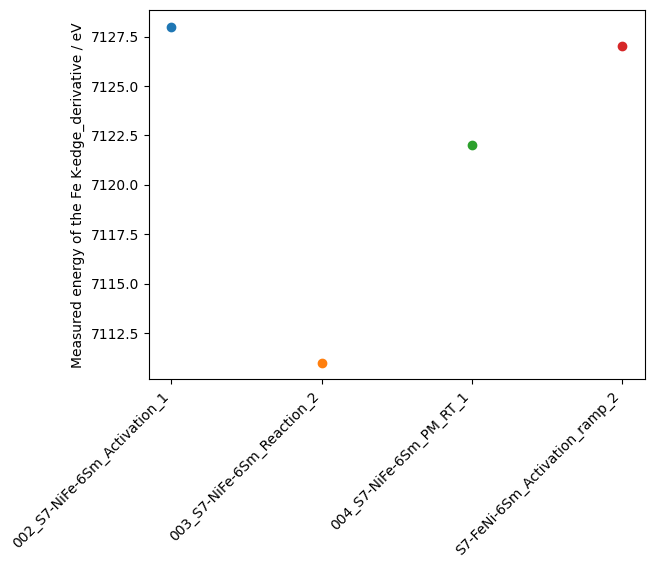

In [50]:
edge_position_list = []
sample_condition_list = []
for (lab, en) in energ_calib_Fe_NEXAFS_list:
    plt.scatter(lab, en*1000)
    print(f"{lab}: has the edge at {en:.4f}")
    edge_position_list.append(float(en))
    sample_condition_list.append(lab)

#print(sample_condition_list)    
#print(edge_position_list)
plt.xticks(rotation=45, ha='right')
plt.ylabel ("Measured energy of the Fe K-edge_derivative / eV")
#plt.savefig('Fe_REF_energy_shift.png')

#Save the edge data in a new file
filename = label.split('_')[0]+"_Fe_EC_position_derivative.dat"  #'sample_data.dat'
#print(filename)

# Writing to csv file
with open(filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    
    # Writing the headers
    writer.writerow(['Condition', 'Corrected_Edge'])
    
    # Writing the data rows
    for condition, edge in zip(sample_condition_list, edge_position_list):
        writer.writerow([condition, edge])

print(f"Data has been written to {filename}")


### Ni K-edge NEXAFS of data- Energy correction

In [8]:
#search_string = "Ni_*_merged"

energy_shifts = [-0.001, -0.002,-0.002,-0.001]

labeled_files= []
for root, dirs, files in os.walk("."):
    files.sort() 
    for i, file in enumerate(files):
        if "Ni_" and "_merged" in file and "Fe" not in file and "Ce" not in file:
            subfolder_name = os.path.basename(root)
            file_path = os.path.join(root, file)
            label = f"{subfolder_name}_{i % 2 +1}"
            labeled_files.append((file_path, label))
labeled_files.sort()
print(labeled_files)

for idx,(file_path, label) in enumerate(labeled_files):
    print (label)
    result_df = pd.read_csv(file_path)
    result_df["monoE"] = result_df["monoE"] + energy_shifts[idx]
    result_df.to_csv(file_path[:-4]+"_EC.dat")
    

[('./002_S7-NiFe-6Sm_Activation/Data_Ni_EXAFS_merged_scans_16_18.csv', '002_S7-NiFe-6Sm_Activation_1'), ('./003_S7-NiFe-6Sm_Reaction/Data_Ni_EXAFS_merged_scans_14_17.csv', '003_S7-NiFe-6Sm_Reaction_2'), ('./004_S7-NiFe-6Sm_PM_RT/Data_Ni_NEXAFS_merged_scans_4_5.csv', '004_S7-NiFe-6Sm_PM_RT_1'), ('./S7-FeNi-6Sm_Activation_ramp/Data_Ni_EXAFS_merged_scans_6_9.csv', 'S7-FeNi-6Sm_Activation_ramp_2')]
002_S7-NiFe-6Sm_Activation_1
003_S7-NiFe-6Sm_Reaction_2
004_S7-NiFe-6Sm_PM_RT_1
S7-FeNi-6Sm_Activation_ramp_2


### Edge position of merged Ni NEXAFS of data

./002_S7-NiFe-6Sm_Activation/Data_Ni_EXAFS_merged_scans_16_18_EC.dat
./003_S7-NiFe-6Sm_Reaction/Data_Ni_EXAFS_merged_scans_14_17_EC.dat
./004_S7-NiFe-6Sm_PM_RT/Data_Ni_NEXAFS_merged_scans_4_5_EC.dat
./S7-FeNi-6Sm_Activation_ramp/Data_Ni_EXAFS_merged_scans_6_9_EC.dat
[('002_S7-NiFe-6Sm_Activation_2', 8.333), ('003_S7-NiFe-6Sm_Reaction_1', 8.333), ('004_S7-NiFe-6Sm_PM_RT_2', 8.337), ('S7-FeNi-6Sm_Activation_ramp_1', 8.345)]


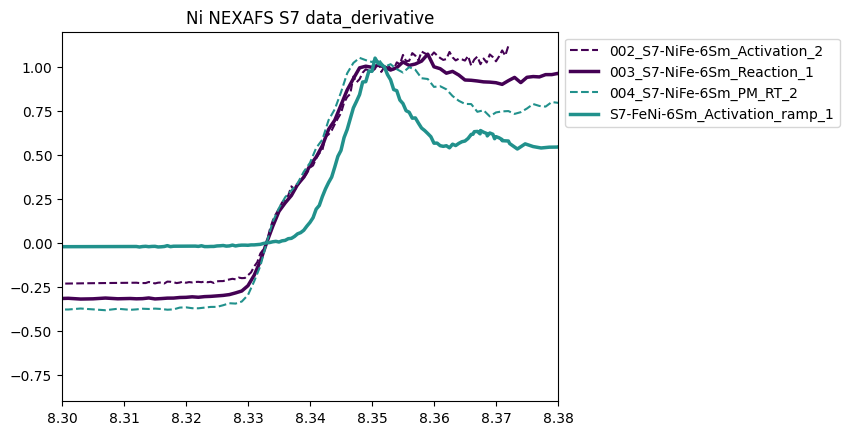

In [11]:
#search_string = "Ni_*_merged" #there are NEXAFS and EXAFS file. I will filter this in another way
search_string_2 = "EC"
var1="roi4" # diode1 / roiX / ionch1
var2="mcaLt" # AS_IC / mcaLt mcaRt

monoE_min = 8.333
monoE_max = 8.352 #8.352 #8.3455
smooth = "yes"


# Ni K-edge is at 8.333 KeV

labeled_files= []
for root, dirs, files in os.walk("."):
    files.sort() 
    for i, file in enumerate(files):
        if "Ni_" and "_merged" in file and "Fe" not in file and "Ce" not in file and search_string_2 in file:
        
        #if search_string in file and search_string_2 in file:
            subfolder_name = os.path.basename(root)
            file_path = os.path.join(root, file)
            label = f"{subfolder_name}_{i % 2 +1}"
            labeled_files.append((file_path, label))
labeled_files.sort()

cmap = plt.cm.viridis
norm = mcolors.Normalize(vmin=0, vmax=len(labeled_files) / 2)
energ_calib_Ni_XAFS_list = []

for idx, (file_path, label) in enumerate(labeled_files):
    print (file_path)
    result_df = pd.read_csv(file_path)

    closest_monoE1 = find_closest(monoE_min, result_df['monoE'])
    closest_monoE2 = find_closest(monoE_max, result_df['monoE'])
    signal_min = result_df.loc[result_df['monoE'] == closest_monoE1, f'{var1}/{var2}_mean'].values[0]
    signal_max = result_df.loc[result_df['monoE'] == closest_monoE2, f'{var1}/{var2}_mean'].values[0]
    color = cmap(norm(idx//2))  # Use the same color for pairs

    x = result_df['monoE']
    result_df["I_norm"]=(result_df[f'{var1}/{var2}_mean'] - signal_min)/(signal_max - signal_min)
    y = -0.0*idx + (result_df["I_norm"])
    err = (result_df[f'{var1}/{var2}_std'] - signal_min)/(signal_max - signal_min)
    
    edge_position = find_edge_position(result_df['monoE'].values, result_df["I_norm"].values, monoE_min, monoE_max, smooth)
            
    # Use the detected edge position to refine your calibration or other calculations
    #edge_energy = result_df['monoE'].iloc[edge_position_idx]  # Energy at the detected edge position

    #target_min = result_df.loc[result_df['monoE'] == closest_monoE1, 'I_norm'].values[0]
    #target_max = result_df.loc[result_df['monoE'] == closest_monoE2, 'I_norm'].values[0]
    #target_value = (target_max - target_min)/2
       
    ## this adds a constrain that the energy edge value should be between the monoE_min and monoE_max values 
    #idx_before = result_df[(result_df["I_norm"] <= target_value) & 
    #                   (result_df['monoE'] >= monoE_min) & 
    #                   (result_df['monoE'] <= monoE_max)].index[-1]

    #idx_after = result_df[(result_df["I_norm"] > target_value) & 
    #                  (result_df['monoE'] >= monoE_min) & 
    #                  (result_df['monoE'] <= monoE_max)].index[0]
    
    
    #x0, y0 = result_df.loc[idx_before, "I_norm"], result_df.loc[idx_before, 'monoE']
    #x1, y1 = result_df.loc[idx_after, "I_norm"], result_df.loc[idx_after, 'monoE']
    #interpolated_monoE = y0 + (target_value - x0) * (y1 - y0) / (x1 - x0)
    energ_calib_Ni_XAFS_list.append((label,float(edge_position)))
    
    
    if label.endswith('_1'):
        plt.plot(x, y, label=label, linewidth=2.5, color=color)
    elif label.endswith('_2'):
        plt.plot(x, y, color=color, linestyle='--', linewidth=1.5, label=label)
    #plt.fill_between(x, y - err,y + err, color=color, alpha=0.2)
print(energ_calib_Ni_XAFS_list)

plt.ylim([-0.9,1.2])
plt.xlim([8.3,8.38])
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title("Ni NEXAFS S7 data_derivative")

plt.savefig('Ni_NEXAFS_S7_data_derivative.png')

002_S7-NiFe-6Sm_Activation_2: has the edge at 8.3330
003_S7-NiFe-6Sm_Reaction_1: has the edge at 8.3330
004_S7-NiFe-6Sm_PM_RT_2: has the edge at 8.3370
S7-FeNi-6Sm_Activation_ramp_1: has the edge at 8.3450
Data has been written to S7-FeNi-6Sm_Ni_EC_position_derivative.dat


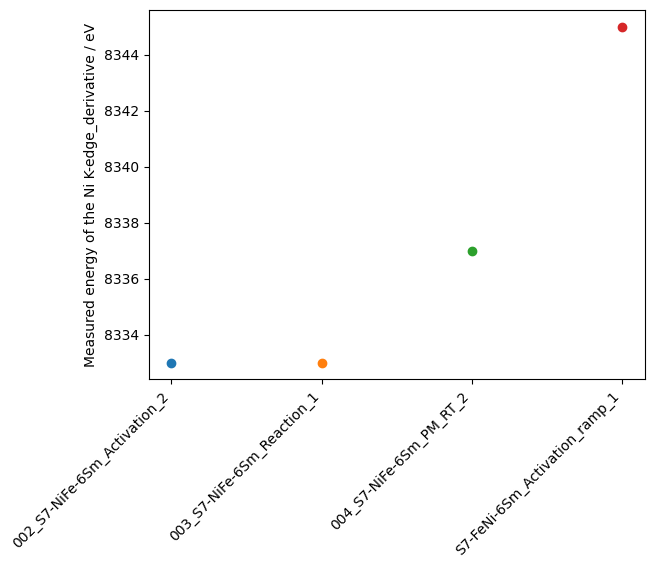

In [12]:
edge_position_list = []
sample_condition_list = []
for (lab, en) in energ_calib_Ni_XAFS_list:
    plt.scatter(lab, en*1000)
    print(f"{lab}: has the edge at {en:.4f}")
    edge_position_list.append(float(en))
    sample_condition_list.append(lab)

#print(sample_condition_list)    
#print(edge_position_list)
plt.xticks(rotation=45, ha='right')
plt.ylabel ("Measured energy of the Ni K-edge_derivative / eV")
#plt.savefig('Fe_REF_energy_shift.png')

#Save the edge data in a new file
filename = label.split('_')[0]+"_Ni_EC_position_derivative.dat"  #'sample_data.dat'
#print(filename)

# Writing to csv file
with open(filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    
    # Writing the headers
    writer.writerow(['Condition', 'Corrected_Edge'])
    
    # Writing the data rows
    for condition, edge in zip(sample_condition_list, edge_position_list):
        writer.writerow([condition, edge])

print(f"Data has been written to {filename}")


### Fe XAS Ref from literature- Extraction of the edge position 

./Fe_REF_XAS.dat
[('Fe foil', 7111.2), ('FeO', 7121.2), ('Fe2O3', 7126.4), ('Fe3O4', 7122.4), ('NiFe2O4', 7126.6)]
Data saved to Fe_REF_XAS_position_derivative.dat


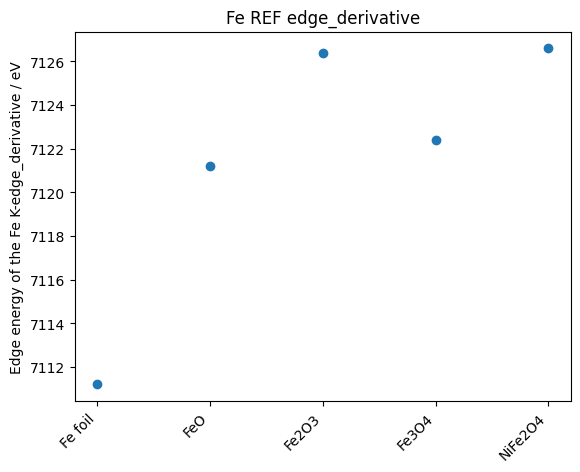

In [23]:
search_string = "Fe_REF_XAS.dat"

monoE_min = 7109
monoE_max = 7134 
#edge = 7.112
# Fe K-edge is at 7.112 KeV
smooth = "yes"

# Walk through the current directory and subdirectories
for root, dirs, files in os.walk("."):
    for i, file in enumerate(files):
        if search_string in file:
            file_path = os.path.join(root, file)
            
            
print(file_path)


result_df = pd.read_csv(file_path, sep='\t')
#print(result_df.head(4))

cmap = plt.cm.viridis
norm = mcolors.Normalize(vmin=0, vmax=(result_df.shape[1]-1) / 2)
energ_calib_Fe_REF_XAS_list = []
if 'Energy' in result_df.columns:
    # Get a list of columns excluding 'Energy'
    columns_to_process = [col for col in result_df.columns if col != 'Energy']
    
    for column in columns_to_process:
        for idx, value in enumerate(result_df[column]):           
            
            edge_energy = find_edge_position(result_df['Energy'].values, result_df[column].values, monoE_min, monoE_max, smooth)
                  
            color = cmap(norm(idx//2))  # Use the same color for pairs
            
            x = result_df['Energy']
            result_df["I"]= result_df[column] 
            y = -0.0*idx + (result_df["I"])

        energ_calib_Fe_REF_XAS_list.append((column,float(edge_energy)))
print(energ_calib_Fe_REF_XAS_list)

#Save the edge data in a new file
filename = "Fe_REF_XAS_position_derivative.dat"  #'sample_data.dat'

# Open the file in write mode
with open(filename, 'w') as file:
    # Write the header
    file.write('Reference,Edge Energy (eV)\n')
    # Write each tuple in the data
    for condition, energy in energ_calib_Fe_REF_XAS_list:
        file.write(f'{condition},{energy}\n')

print(f'Data saved to {filename}')


# Extract x and y values
x_labels = [item[0] for item in energ_calib_Fe_REF_XAS_list]
y_values = [item[1] for item in energ_calib_Fe_REF_XAS_list]

# Create a scatter plot
plt.scatter(x_labels, y_values)
plt.xticks(rotation=45, ha='right')
plt.ylabel ("Edge energy of the Fe K-edge_derivative / eV")
#plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title("Fe REF edge_derivative")
plt.savefig('Fe_REF_XAS_edge_derivative.png')

### Ni XAS Ref from literature - Extraction of the edge position 

./Ni_REF_XAS.dat
[('Ni metal', 8333.6), ('NiO', 8346.8), ('NiF2O4', 8345.2)]
Data saved to Ni_REF_XAS_position_derivative.dat


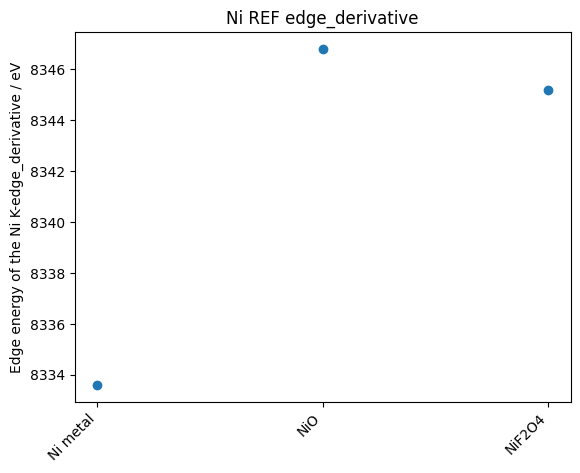

In [19]:
search_string = "Ni_REF_XAS.dat"

#edge = 8.33
# Ni K-edge is at 8.33 KeV

# Walk through the current directory and subdirectories
for root, dirs, files in os.walk("."):
    for i, file in enumerate(files):
        if search_string in file:
            file_path = os.path.join(root, file)
                      
print(file_path)

result_df = pd.read_csv(file_path, sep='\t')

cmap = plt.cm.viridis
norm = mcolors.Normalize(vmin=0, vmax=(result_df.shape[1]-1) / 2)

monoE_min = 8323
monoE_max = 8352
#monoE_max_metal = 8335
smooth = "no"

energ_calib_Ni_REF_XAS_list = []

if 'Energy' in result_df.columns:
    # Get a list of columns excluding 'Energy'
    columns_to_process = [col for col in result_df.columns if col != 'Energy']
    
    for column in columns_to_process:
        for idx, value in enumerate(result_df[column]):
                        
            #closest_monoE1 = find_closest(monoE_min, result_df['Energy'])
            #if column == 'Ni metal':
            #    closest_monoE2 = find_closest(monoE_max_metal, result_df['Energy'])
            #else:
            #    closest_monoE2 = find_closest(monoE_max, result_df['Energy'])
            
            #signal_min = result_df.loc[result_df['Energy'] == closest_monoE1, column].values[0]
            #signal_max = result_df.loc[result_df['Energy'] == closest_monoE2, column].values[0]
            
            edge_position = find_edge_position(result_df['Energy'].values, result_df[column].values, monoE_min, monoE_max, smooth)
            
            # Use the detected edge position to refine your calibration or other calculations
            #edge_energy = result_df['Energy'].iloc[edge_position_idx]  # Energy at the detected edge position

            
            color = cmap(norm(idx//2))  # Use the same color for pairs
            
            x = result_df['Energy']
            result_df["I"]= result_df[column] 
            y = -0.0*idx + (result_df["I"])
            #err = (result_df[f'{var1}/{var2}_std'] - signal_min)/(signal_max - signal_min)
            
            #target_min = result_df.loc[result_df['Energy'] == closest_monoE1, 'I'].values[0]
            #target_max = result_df.loc[result_df['Energy'] == closest_monoE2, 'I'].values[0]
            #target_value = (target_max - target_min)/2
            
            ## this adds a constrain that the energy edge value should be between the monoE_min and monoE_max values 
            #idx_before = result_df[(result_df["I"] <= target_value) & 
            #                (result_df['Energy'] >= monoE_min) & 
            #                (result_df['Energy'] <= monoE_max)].index[-1]

            #idx_after = result_df[(result_df["I"] > target_value) & 
            #                (result_df['Energy'] >= monoE_min) & 
            #                (result_df['Energy'] <= monoE_max)].index[0]
            
            
            #x0, y0 = result_df.loc[idx_before, "I"], result_df.loc[idx_before, 'Energy']
            #x1, y1 = result_df.loc[idx_after, "I"], result_df.loc[idx_after, 'Energy']
            #interpolated_monoE = y0 + (target_value - x0) * (y1 - y0) / (x1 - x0)
        #energ_calib_Ni_REF_XAS_list.append((column,float(interpolated_monoE)))
        energ_calib_Ni_REF_XAS_list.append((column,float(edge_position)))
print(energ_calib_Ni_REF_XAS_list)

#Save the edge data in a new file
filename = "Ni_REF_XAS_position_derivative.dat"  #'sample_data.dat'

# Open the file in write mode
with open(filename, 'w') as file:
    # Write the header
    file.write('Reference,Edge Energy (eV)\n')
    # Write each tuple in the data
    for condition, energy in energ_calib_Ni_REF_XAS_list:
        file.write(f'{condition},{energy}\n')

print(f'Data saved to {filename}')

# Extract x and y values
x_labels = [item[0] for item in energ_calib_Ni_REF_XAS_list]
y_values = [item[1] for item in energ_calib_Ni_REF_XAS_list]

# Create a scatter plot
plt.scatter(x_labels, y_values)
plt.xticks(rotation=45, ha='right')
plt.ylabel ("Edge energy of the Ni K-edge_derivative / eV")
#plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title("Ni REF edge_derivative")
plt.savefig('Ni_REF_XAS_edge_derivative.png')